In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme()

import torch 
import torch.nn as nn 
import torch.optim as optim


from models.learned_qp_solver_bi_cycle_steer_part import MLP_Init as MLP_Init_steer
from models.learned_qp_solver_bi_cycle_steer_part import learned_qp_solver as learned_qp_solver_steer


from models.learned_qp_solver_bi_cycle_vel_part import MLP_Init as MLP_Init_vel
from models.learned_qp_solver_bi_cycle_vel_part import learned_qp_solver as learned_qp_solver_vel

from scipy.io import loadmat
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [3]:
num = 50
t = 0.1


vel_min = 0.0
vel_max = 30.0

acc_min = -6.0
acc_max = 6.0

jerk_min = -6.0
jerk_max = 6.0

steer_min = -0.8
steer_max = 0.8

steerdot_min = -1.0
steerdot_max = 1.0

steerddot_min = -1.0
steerddot_max = 1.0

x_init = 0.0
y_init = 0.0
psi_init = 0.0

In [4]:
v_des =  np.random.uniform(vel_min, vel_max)

num_batch = 500

# vel_samples = np.random.uniform(vel_min, vel_max,  (num_batch, num)    )
vel_samples = np.random.multivariate_normal(v_des*np.ones(num), 5*np.identity(num), (num_batch, ) )


vel_samples = np.clip( vel_samples, vel_min, vel_max  )


# vel_init = np.random.uniform(vel_min, vel_max)*np.ones((num_batch , 1)) 
vel_init = v_des*np.ones((num_batch , 1)) 


inp_vel = np.hstack(( vel_samples, vel_init))

median_vel = np.array([15.04770936, 15.05825353, 15.05594789, 14.98925399, 14.9813385 ,
       14.9803559 , 15.01201724, 15.05104337, 14.99071299, 14.99062193,
       14.97814039, 14.98633039, 15.05541669, 15.00973865, 14.97581504,
       14.95434159, 15.08204415, 14.95716258, 15.00798985, 15.02159146,
       15.00003375, 14.99012723, 15.03607882, 15.04781101, 15.02108329,
       14.99038303, 14.95707157, 15.04866477, 14.95856117, 15.01981668,
       15.03673595, 15.06312754, 15.01430138, 14.99278037, 14.95117927,
       15.00640649, 15.05287354, 15.01712211, 15.03036029, 14.96818817,
       14.9910865 , 14.97771491, 14.96045441, 14.96508377, 15.01555771,
       15.00657147, 15.01346687, 14.940316  , 14.94994511, 14.93062279,
       14.98692683])
iqr_vel = np.array([14.9777    , 15.00083603, 14.97139699, 15.04253366, 14.93629004,
       14.98271924, 14.97111582, 14.99223769, 14.99461593, 15.04091625,
       14.98874495, 14.9530227 , 15.00100103, 15.02562935, 15.03006681,
       14.93371082, 14.98533277, 14.99880901, 15.02006062, 15.01890364,
       14.98858154, 15.00740713, 15.01604546, 14.9594738 , 14.99473523,
       15.02132751, 15.03434268, 15.00192548, 14.95726139, 15.0006366 ,
       14.99938233, 15.05135302, 15.04369568, 14.99526296, 15.00659418,
       14.99475534, 14.92703994, 15.03509243, 15.03765378, 15.04014261,
       14.99201848, 14.99597215, 15.02974453, 14.98373521, 14.98758812,
       14.98576964, 14.99339567, 15.01782907, 14.9853818 , 15.06120483,
       15.04379853])




median_vel = torch.tensor(median_vel).float().to(device)
iqr_vel = torch.tensor(iqr_vel).float().to(device)

In [5]:
steer_des =  0.0*np.random.uniform(steer_min, steer_max)

num_batch = 500

# vel_samples = np.random.uniform(vel_min, vel_max,  (num_batch, num)    )
steer_samples = np.random.multivariate_normal(steer_des*np.ones(num), 1*np.identity(num), (num_batch, ) )


steer_samples = np.clip( steer_samples, steer_min, steer_max  )


# vel_init = np.random.uniform(vel_min, vel_max)*np.ones((num_batch , 1)) 
steer_init = steer_des*np.ones((num_batch , 1)) 


inp_steer = np.hstack(( steer_samples, steer_init))


median_steer = np.array([-4.30842576e-04,  5.91636819e-05, -1.98533905e-03,  1.95326047e-03,
       -1.39358004e-03, -5.68464714e-05,  2.65373538e-04, -2.05526464e-03,
       -7.79943244e-04, -2.89536127e-04, -1.67782600e-03, -1.30369985e-03,
        1.54351594e-03, -2.10914668e-03, -8.94449061e-04, -1.12731106e-04,
        1.39067091e-03,  2.35456389e-03,  1.13105755e-03, -1.60172509e-03,
        5.96616154e-04,  4.50916455e-04,  1.03440312e-03,  2.20521562e-03,
        1.91066337e-03, -2.36909941e-03,  5.23557830e-04,  3.22519684e-03,
       -6.10364108e-04, -1.55881571e-03, -2.54650519e-04,  5.49939732e-04,
       -2.54372567e-03,  1.15624681e-03,  3.09751082e-03, -1.01707749e-03,
       -1.16847934e-03, -9.60229520e-04,  3.19715942e-04, -7.80995571e-04,
        3.91363172e-04,  1.96635947e-05, -2.01634184e-04, -1.34935042e-03,
       -1.25220145e-03,  1.28156314e-04,  1.63297072e-03, -2.31602556e-03,
        8.75998110e-04, -2.06147938e-04,  1.15305881e-03])
iqr_steer = np.array([0.80001846, 0.79929592, 0.79676276, 0.79730429, 0.79646984,
       0.79966968, 0.80083456, 0.80339261, 0.79957275, 0.80271643,
       0.79956587, 0.7986954 , 0.80184285, 0.79680465, 0.79700468,
       0.80111911, 0.80292797, 0.79760931, 0.8001852 , 0.79991013,
       0.80251082, 0.80016607, 0.80274812, 0.7996054 , 0.79708629,
       0.79890295, 0.8011802 , 0.79833857, 0.80142342, 0.80023931,
       0.80009408, 0.79791844, 0.79955642, 0.79824443, 0.79912222,
       0.79983322, 0.80107271, 0.79787763, 0.80142027, 0.79819341,
       0.79860864, 0.79933899, 0.7980339 , 0.79911936, 0.79988434,
       0.79932644, 0.79560559, 0.79765311, 0.79994117, 0.80107361,
       0.79731313])


median_steer = torch.tensor(median_steer).float().to(device)
iqr_steer = torch.tensor(iqr_steer).float().to(device)

In [6]:
mlp_init_inp_dim_vel = np.shape(inp_vel)[1]
mlp_init_hidden_dim_vel = 1024
# mlp_init_out_dim = (2*nvar)**2+2*nvar+2*nvar
mlp_init_out_dim = num+(2*num+2*(num-1)+2*(num-2))

# mlp_pred = MLP_Pred(mlp_pred_inp_dim, mlp_pred_hidden_dim, mlp_pred_out_dim  )
mlp_init_vel = MLP_Init_vel(mlp_init_inp_dim_vel, mlp_init_hidden_dim_vel, mlp_init_out_dim  )


model_vel = learned_qp_solver_vel(num_batch, num, t, mlp_init_vel).to(device)
model_vel.load_state_dict(torch.load('./weights/learned_qp_bi_cycle_vel_part.pth'))


<All keys matched successfully>

In [7]:

mlp_init_inp_dim_steer = np.shape(inp_steer)[1]
mlp_init_hidden_dim_steer = 1024
# mlp_init_out_dim = (2*nvar)**2+2*nvar+2*nvar
mlp_init_out_dim_steer = num+(2*num+2*(num-1)+2*(num-2))
# print((2*num+2*(num-1)+2*(num-2)))

# mlp_pred = MLP_Pred(mlp_pred_inp_dim, mlp_pred_hidden_dim, mlp_pred_out_dim  )
mlp_init_steer = MLP_Init_steer(mlp_init_inp_dim_steer, mlp_init_hidden_dim_steer, mlp_init_out_dim_steer  )


model_steer = learned_qp_solver_steer(num_batch, num, t, mlp_init_steer).to(device)
model_steer.load_state_dict(torch.load('./weights/learned_qp_bi_cycle_steer_part.pth'))

<All keys matched successfully>

In [8]:
inp_test_vel = inp_vel
inp_test_vel = torch.tensor(inp_test_vel).float()
inp_test_vel = inp_test_vel.to(device)
# inp_test = torch.vstack([inp_test] * num_batch)
# inp_norm_test = (inp_test - inp_mean) / inp_std
inp_norm_test_vel = (inp_test_vel-median_vel)/iqr_vel
# inp_norm_test = (inp_test - inp_min) / (inp_max-inp_min)

# inp_norm_test = inp_test 



vel_init_test = vel_init[0]
vel_init_test = torch.tensor(vel_init_test).float()
vel_init_test = vel_init_test.to(device)



# vel_init_test = torch.vstack([vel_init_test] * num_batch)


vel_samples_test = vel_samples
vel_samples_test = torch.tensor(vel_samples_test).float()
vel_samples_test = vel_samples_test.to(device)
# vel_samples_test = torch.vstack([vel_samples_test] * num_batch)

with torch.no_grad():
    vel_projected, res_primal_stack_vel, res_fixed_point_stack_vel, accumulated_res_primal_vel, accumulated_res_fixed_point_vel = model_vel.decoder_function(inp_norm_test_vel, vel_init_test, vel_samples_test, vel_max, vel_min, acc_max, acc_min, jerk_max, jerk_min)




In [9]:
inp_test_steer = inp_steer
inp_test_steer = torch.tensor(inp_test_steer).float()
inp_test_steer = inp_test_steer.to(device)
# inp_test = torch.vstack([inp_test] * num_batch)
# inp_norm_test = (inp_test - inp_mean) / inp_std
inp_norm_test_steer = (inp_test_steer-median_steer)/iqr_steer
# inp_norm_test = (inp_test - inp_min) / (inp_max-inp_min)

# inp_norm_test = inp_test 



steer_init_test = steer_init[0]
steer_init_test = torch.tensor(steer_init_test).float()
steer_init_test = steer_init_test.to(device)



# vel_init_test = torch.vstack([vel_init_test] * num_batch)


steer_samples_test = steer_samples
steer_samples_test = torch.tensor(steer_samples_test).float()
steer_samples_test = steer_samples_test.to(device)


with torch.no_grad():
    steer_projected, res_primal_stack_steer, res_fixed_point_stack_steer, accumulated_res_primal_steer, accumulated_res_fixed_point_steer = model_steer.decoder_function( inp_norm_test_steer, steer_init_test, steer_samples_test, steer_max, steer_min, steerdot_max, steerdot_min, steerddot_max, steerddot_min)



In [10]:
def compute_rollouts(x_init, y_init, psi_init, v, steer):

    psidot = v/2.5*(torch.tan(steer))

    psi_samples = psi_init+torch.cumsum(psidot*t, dim = 1)

    vx = v*torch.cos(psi_samples)
    vy = v*torch.sin(psi_samples)

    x_samples = x_init+torch.cumsum(vx*t, dim = 1)
    y_samples = y_init+torch.cumsum(vy*t, dim = 1)

    return x_samples, y_samples, psi_samples
    


x_samples_smooth, y_samples_smooth, psi_samples_smooth = compute_rollouts(x_init, y_init, psi_init, vel_projected, steer_projected)
# x_samples, y_samples, psi_samples = compute_rollouts(x_init, y_init, psi_init, vel_samples, steer_samples)


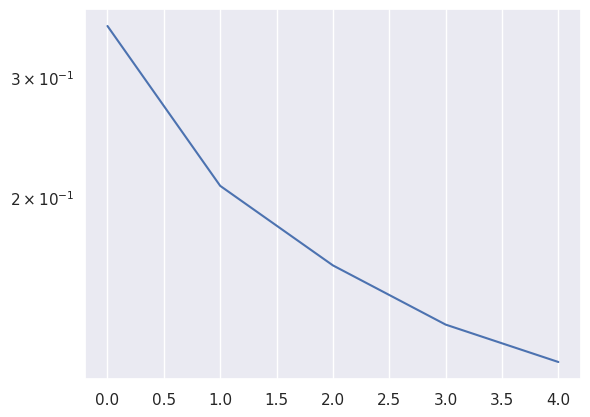

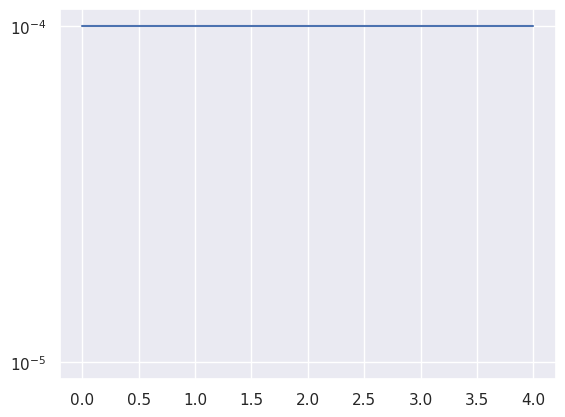

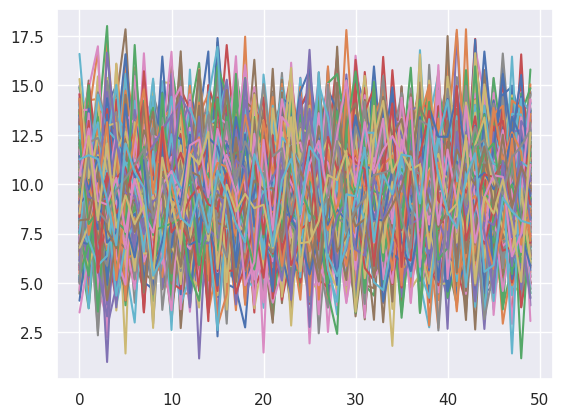

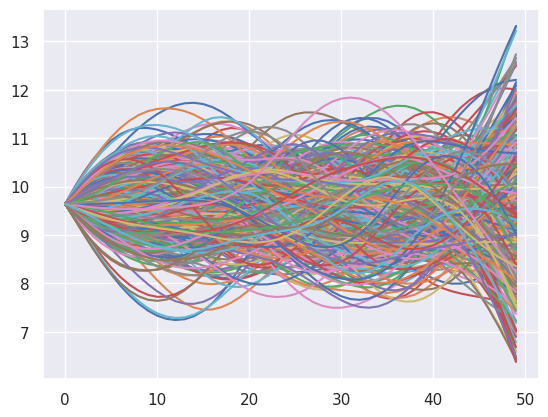

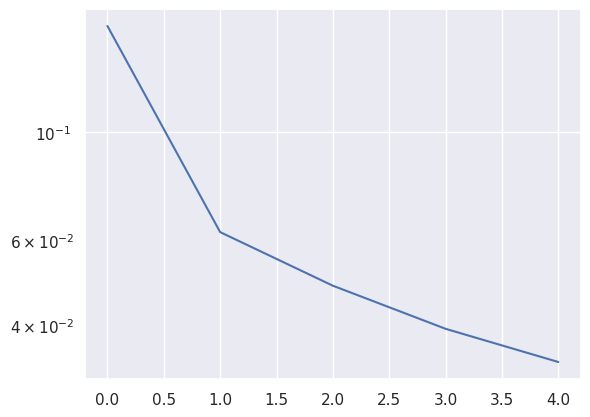

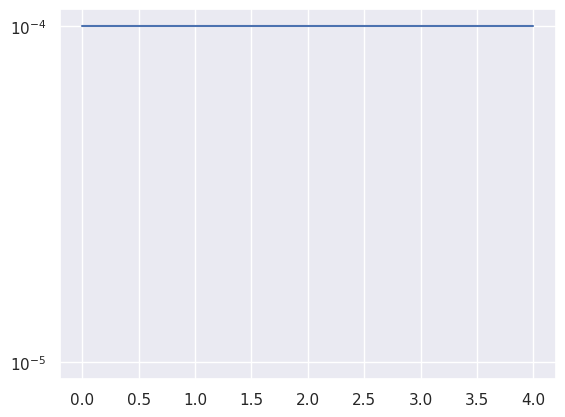

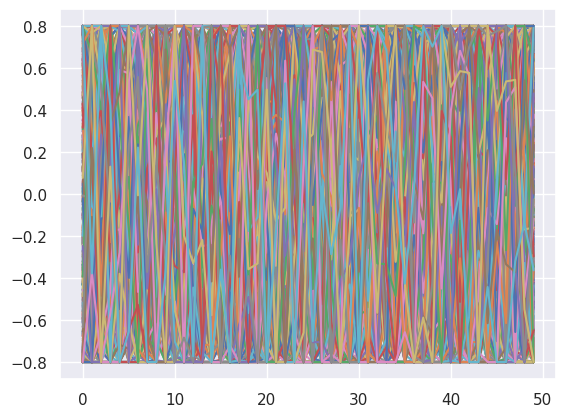

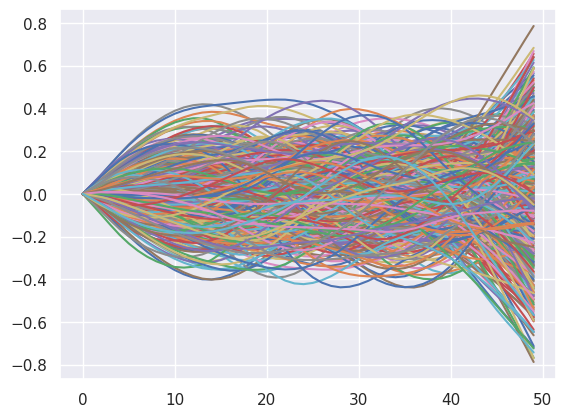

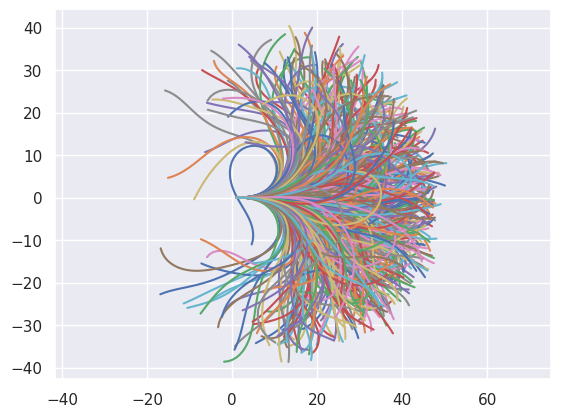

In [11]:
plt.figure(1)
plt.plot(res_fixed_point_stack_vel[:, 0].cpu().detach().numpy())
plt.yscale('log')


plt.figure(2)
plt.plot(res_primal_stack_vel[:, 0].cpu().detach().numpy()+0.0001)
plt.yscale('log')


plt.figure(3)

plt.plot(vel_samples_test.T.cpu().detach().numpy())

plt.figure(4)
plt.plot(vel_projected.T.cpu().detach().numpy())


plt.figure(5)
plt.plot(res_fixed_point_stack_steer[:, 0].cpu().detach().numpy())
plt.yscale('log')


plt.figure(6)
plt.plot(res_primal_stack_steer[:, 0].cpu().detach().numpy()+0.0001)
plt.yscale('log')


plt.figure(7)

plt.plot(steer_samples_test.T.cpu().detach().numpy())

plt.figure(8)
plt.plot(steer_projected.T.cpu().detach().numpy())


plt.figure(9)
plt.plot(x_samples_smooth.T.cpu().detach().numpy(), y_samples_smooth.T.cpu().detach().numpy())
plt.axis('equal')

plt.show()


plt.show()
